In [1]:
#  Imports
from src.parsers import HMParser
from src.resources import BinaryResource, Generator, Load, Storage, Vehicle
from src.scenes import HMProblemScene

import numpy as np
import matplotlib.pyplot as plt
import copy

# Ignore the warnings (only demonstration purposes!)
import warnings
warnings.filterwarnings("ignore")

2024-01-03 18:03:27,819	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
# Data parsing

data = HMParser(file_path='data/EC_V4.xlsx', ec_id=1)
data.parse()

In [3]:
# Do a backup of the data

# Multiply every resource by a factor of 10
# Always check for one dimensional arrays

new_data = copy.deepcopy(data)

FACTOR = 10

# Generators
for key in new_data.generator.keys():

    # Check if the array is one dimensional
    if len(new_data.generator[key].shape) == 1:
        new_data.generator[key] = np.tile(new_data.generator[key], (FACTOR, ))
    else:
        # Add in n times
        new_data.generator[key] = np.tile(new_data.generator[key], (FACTOR, 1))

    # Add some noise to the GenActivePower
    if key == 'genActPower':
        new_data.generator[key] = new_data.generator[key] + np.random.normal(0, 0.1, len(new_data.generator[key])) if new_data.generator[key] > 0 else 0

# Loads
for key in new_data.load.keys():

    # Check if the array is one dimensional
    if len(new_data.load[key].shape) == 1:
        new_data.load[key] = np.tile(new_data.load[key], (FACTOR, ))
    else:
        # Add in n times
        new_data.load[key] = np.tile(new_data.load[key], (FACTOR, 1))

    # Add some noise to the LoadActivePower
    if key == 'loadActPower':
        new_data.load[key] = new_data.load[key] + np.random.normal(0, 0.1, len(new_data.load[key])) if new_data.load[key] > 0 else 0

# Storages
for key in new_data.storage.keys():

    # Check if the array is one dimensional
    if len(new_data.storage[key].shape) == 1:
        new_data.storage[key] = np.tile(new_data.storage[key], (FACTOR, ))
    else:
        # Add in n times
        new_data.storage[key] = np.tile(new_data.storage[key], (FACTOR, 1))

# EVs
for key in new_data.vehicle.keys():

    # Check if the array is one dimensional
    if len(new_data.vehicle[key].shape) == 1:
        new_data.vehicle[key] = np.tile(new_data.vehicle[key], (FACTOR, ))
    else:
        # Add in n times
        new_data.vehicle[key] = np.tile(new_data.vehicle[key], (FACTOR, 1))

# Increase the import and export maximum values by a factor of 10 to keep up
new_data.peers['import_contracted_p_max'] = new_data.peers['import_contracted_p_max'] * FACTOR
new_data.peers['export_contracted_p_max'] = new_data.peers['export_contracted_p_max'] * FACTOR

# Do a backup of the data
data_backup = copy.deepcopy(data)

# Assign the new data to original data
data = copy.deepcopy(new_data)

In [4]:
new_data.storage.keys()

dict_keys(['p_charge_limit', 'p_discharge_limit', 'charge_price', 'discharge_price', 'internal_bus_location', 'battery_type', 'owner', 'manager', 'type_contract', 'energy_capacity', 'energy_min_percentage', 'charge_efficiency', 'discharge_efficiency', 'initial_state', 'p_charge_max', 'p_discharge_max'])

In [5]:
# Define generators
gens = Generator(name='gens',
                 value=np.zeros(data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(data.generator['p_forecast'].shape),
                 upper_bound=data.generator['p_forecast'],
                 cost=data.generator['cost_parameter_b'],
                 cost_nde=data.generator['cost_nde'],
                 is_renewable=data.generator['type_generator'])

# Define loads
loads = Load(name='loads',
             value=data.load['p_forecast'],
             lower_bound=np.zeros(data.load['p_forecast'].shape),
             upper_bound=data.load['p_forecast'],
             cost=np.ones(data.load['p_forecast'].shape),
             cost_cut=data.load['cost_cut'],
             cost_reduce=data.load['cost_reduce'],
             cost_ens=data.load['cost_ens'])

# Define storage
stor = Storage(name='stor',
               value=np.zeros(data.storage['p_charge_limit'].shape),
               lower_bound=np.zeros(data.storage['p_charge_limit'].shape),
               upper_bound=(data.storage['energy_capacity'] *
                            np.ones(data.storage['p_charge_limit'].shape).transpose()).transpose(),
               cost=np.ones(data.storage['p_charge_limit'].shape),
               cost_discharge=data.storage['discharge_price'],
               cost_charge=data.storage['charge_price'],
               capacity_max=data.storage['energy_capacity'],
               capacity_min=data.storage['energy_min_percentage'],
               initial_charge=data.storage['initial_state'],
               discharge_efficiency=data.storage['discharge_efficiency'],
               discharge_max=data.storage['p_discharge_limit'],
               charge_efficiency=data.storage['charge_efficiency'],
               charge_max=data.storage['p_charge_limit'],
               capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), FACTOR))

# Define vehicle to grid
v2g = Vehicle(name='evs',
              value=np.zeros(data.vehicle['schedule_charge'].shape),
              lower_bound=(data.vehicle['e_capacity_max'] * data.vehicle['min_technical_soc'] *
                           np.ones(data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              upper_bound=(data.vehicle['e_capacity_max'] * np.ones(data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              cost=np.ones(data.vehicle['schedule_charge'].shape),
              cost_discharge=data.vehicle['discharge_price'][:, 0],
              cost_charge=data.vehicle['charge_price'][:, 0],
              capacity_max=data.vehicle['e_capacity_max'],
              initial_charge=np.ones(data.vehicle['schedule_charge'].shape) * 0.8,
              min_charge=data.vehicle['min_technical_soc'],
              discharge_efficiency=data.vehicle['discharge_efficiency'],
              charge_efficiency=data.vehicle['charge_efficiency'],
              capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), FACTOR),
              schedule_discharge=data.vehicle['schedule_discharge'],
              schedule_charge=data.vehicle['schedule_charge'])

# Define imports and exports
pimp = BinaryResource(name='pImp',
                      value=np.zeros(data.peers['import_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(data.peers['import_contracted_p_max'][0, :].shape),
                      upper_bound=data.peers['import_contracted_p_max'][0, :],
                      cost=data.peers['buy_price'][0, :],
                      is_active=np.zeros(data.peers['import_contracted_p_max'][0, :].shape))

pexp = BinaryResource(name='pExp',
                      value=np.zeros(data.peers['export_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(data.peers['export_contracted_p_max'][0, :].shape),
                      upper_bound=data.peers['export_contracted_p_max'][0, :],
                      cost=data.peers['sell_price'][0, :],
                      is_active=np.zeros(data.peers['export_contracted_p_max'][0, :].shape))

# Establish the components
ec_components = {'gen': gens,
                 'loads': loads,
                 'stor': stor,
                 'evs': v2g,
                 'pimp': pimp,
                 'pexp': pexp}

ec_components

{'gen': gens,
 'loads': loads,
 'stor': stor,
 'evs': evs,
 'pimp': pImp,
 'pexp': pExp}

In [ ]:
# Create the scene

scene = HMProblemScene(name='EC1', data=ec_components, hm_parser=data, pop_size=20,
                       n_iter=10000, iter_tolerance=1000)
scene.initialize()
scene.run()

 16%|█▋        | 1631/10000 [03:16<16:24,  8.50it/s]

In [10]:
#scene.components['evs'].capital_cost
v2g.cost_discharge

array([0.05, 0.06, 0.05, 0.05, 0.06, 0.05, 0.06, 0.05, 0.05, 0.06, 0.05,
       0.06, 0.05, 0.05, 0.06, 0.05, 0.06, 0.05, 0.05, 0.06, 0.05, 0.06,
       0.05, 0.05, 0.06, 0.05, 0.06, 0.05, 0.05, 0.06, 0.05, 0.06, 0.05,
       0.05, 0.06, 0.05, 0.06, 0.05, 0.05, 0.06, 0.05, 0.06, 0.05, 0.05,
       0.06, 0.05, 0.06, 0.05, 0.05, 0.06], dtype=object)

In [9]:
# Sum matrices along the columns

scene.algo.population_fitness

401

In [7]:
 # Check the population

scene.algo.population

array([[0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [8]:
scene.current_best

{'genActPower': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., 30.,  0., ...,  0., 30., 30.],
        [10., 10.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 'genExcActPower': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'pImp': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]),
 'pExp': array([ 21.3024178 , 128.61334431,  53.97509655, 322.68901126,
        223.64546578, 213.69970449, 305.55134675, 276.98338484,
        440.03030299, 304.67007272, 376.07203506, 486.03224242,
        432.38111178, 376.54463532, 370.32846793, 366.75765094,
        318.07452812, 209.70008103, 105.8039798

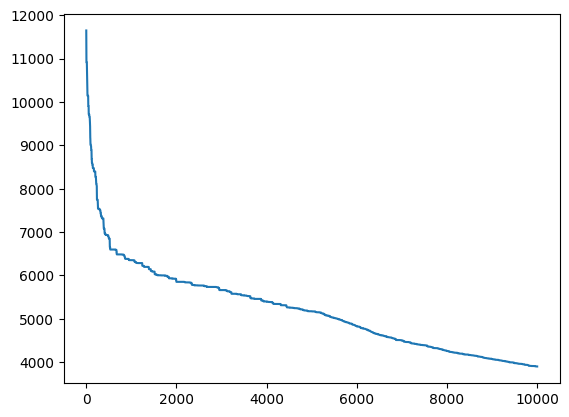

In [9]:
plt.plot(scene.algo.population_history_fitness)

In [10]:
scene.algo.population_history_fitness

[11646.078113670144,
 11289.014359531506,
 11169.261062398587,
 11012.385960993157,
 10910.871502678418,
 10910.871502678418,
 10910.871502678418,
 10910.871502678418,
 10910.871502678418,
 10910.871502678418,
 10910.871502678418,
 10910.871502678418,
 10910.871502678418,
 10894.75028264967,
 10830.039959415186,
 10780.78400219949,
 10780.78400219949,
 10780.78400219949,
 10634.649717705244,
 10634.649717705244,
 10582.89391859848,
 10307.60249578744,
 10280.782788136368,
 10143.083463564784,
 10143.083463564784,
 10143.083463564784,
 10143.083463564784,
 10143.083463564784,
 10143.083463564784,
 10143.083463564784,
 10143.083463564784,
 10143.083463564784,
 10143.083463564784,
 10143.083463564784,
 10143.083463564784,
 10143.083463564784,
 10143.083463564784,
 10143.083463564784,
 10143.083463564784,
 10143.083463564784,
 10143.083463564784,
 10133.349531218284,
 10133.349531218284,
 9903.981305725441,
 9903.981305725441,
 9903.981305725441,
 9903.981305725441,
 9903.981305725441,
 99

In [11]:
scene.algo.population_fitness

[3905.715708640027,
 3911.608260567952,
 3901.553578510143,
 3909.331111875429,
 3914.6580132758636,
 3922.7228345393964,
 3904.478716706658,
 3917.139872260279,
 3906.498652099075,
 3912.6840544592983,
 3902.5143938847123,
 3921.3108472776553,
 3912.3582746575644,
 3915.2375189257973,
 3901.5672239439045,
 3902.909375878332,
 3914.891026728744,
 3902.1881975088722,
 3915.1375098108365,
 3920.6580220610863]

In [12]:
scene.current_best_fitness

220.66186507651932